## Rat 05 inverse problem with hyper elasticity

## Original ran a long time ago

Interpolating ic...
Interpolating tumor...
Plotting initial condition and target...


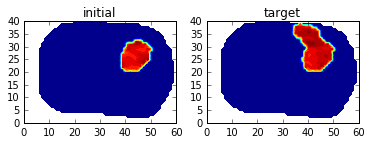

Optimizing...
Running the forward problem...
Solving reaction diffusion for time = 0.0
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Running the forward problem...
Solving reaction diffusion for time = 0.0
Plotting initial condition and target...


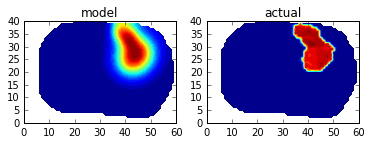

norm(k_opt) = 15.0480399815
J_opt = 188.212904229
J_opt (without regularization) = 185.913485414
D0 = 4.44796222777
Elapsed time is 8.04342650948 minutes


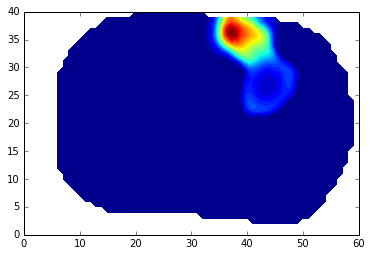

In [2]:
%matplotlib inline
from __future__ import print_function
from dolfin import *
from dolfin_adjoint import *
import numpy as np
import os, sys
import scipy.io as scio
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors

set_log_level(ERROR) 

class InterpolatedParameter(Expression):
    '''
        Class to get tumor cell distributions by interpolating based off matrices of tumor cell data
    '''
    def __init__(self,X,Y,image,**kwargs):
        self.X = X # A numpy array giving the X-spacing of the image
        self.Y = Y # Same for Y
        self.image = image # The image of measured material property    
    def eval_cell(self,values,x,cell):
        interp_handle = RegularGridInterpolator((self.X,self.Y),self.image)
        values[0] = interp_handle(x)
        
def interp(file_loc,mat_name):
    """
        Function to accept matlab .mat file with tumor data and interpolate values onto mesh
    """
    print("Interpolating "+mat_name+"...")
    mat = scio.loadmat(file_loc)[mat_name]
    mat = np.fliplr(mat.T)/theta  # Needs to be adjusted to fit the mesh correctly; also scaled
    x,y = mat.shape[0], mat.shape[1]
    mat_interp = InterpolatedParameter(np.linspace(1,x,x),np.linspace(1,y,y),mat,degree=1)
    return interpolate(mat_interp,V)

def vis_obs(initial_p,target_p,title1,title2):
    '''
        Compare two quantity plots, for example initial vs. target cellularity
        Accepts titles for each plot
    '''
    print("Plotting initial condition and target...")
    target_p = interpolate(target_p,V)
    cm1 = colors.ListedColormap([[0,1,0,1],[0,0,0,1],[1,0,0,1]])    
    cm2 = cm.get_cmap('jet')
    plt.figure()
    plt.subplot(1,2,1)
    plt.title(title1)
    plot(initial_p,cmap=cm2)
 
    plt.subplot(1,2,2)
    plt.title(title2)
    plot(target_p,cmap=cm2)
    plt.show()

def forward(initial_p,record=True, annotate=False):
    print("Running the forward problem...")
    
    """ 
        Here, we define the forward problem. 
    """
    
    '''
        - E(u) returns the Green-Lagrange strain tensor
        - sigma(...) returns the actual stress tensor
        - sigma_form(...) returns the stress tensor based on the cells (phi), elasticity coefficients, and a coefficient beta
        - vonmises(...) calculates the von Mises stress based on the actual stress tensor
    '''
    
    ## Define functions
    def E(u):
        return 0.5*(nabla_grad(u) + nabla_grad(u).T)
    def sigma(u):
        I = Identity(2)             # Identity tensor
        F = I + grad(u)             # Deformation gradient
        B = F*F.T
        C = F.T*F
        J = det(F)
        I1 = tr(C)
        sigma = lmbda*(J-1)*I+mu*(B-1./2*I1*I)/(J**(5./3))
        return sigma
    def vonmises(u):
        s = sigma(u) - (1./2)*tr(sigma(u))*Identity(2)  # deviatoric stress
        von_Mises = sqrt(3./2*inner(s, s))
        return project(von_Mises, V,annotate=annotate)
    def sigma_form(u, phi):
        I = Identity(2)             # Identity tensor
        F = I + grad(u)             # Deformation gradient
        Fs = F/(1+beta*phi)
        Bs = Fs*Fs.T
        Js  = det(Fs)
        return 1/(1+beta*phi)*(mu/(Js**(5./3))*(Bs-1./2*tr(Bs)*I)+lmbda*(Js-1)*I)

    # Set up linear elasticity problem
    U           = VectorFunctionSpace(mesh,'Lagrange',1)
    def boundary(x, on_boundary):
        return on_boundary
    bc          = DirichletBC(U, Constant((0.,0.)), boundary)
    du          = TrialFunction(U)
    u           = Function(U,annotate = annotate) 
    v           = TestFunction(U)
    p_n         = interpolate(initial_p,V)
    F_HE        = inner(sigma_form(u, p_n), E(v))*dx
    J_HE        = derivative(F_HE,u,du)
    
    ffc_options = {"quadrature_degree": 2, "cpp_optimize": True}
    parameters['form_compiler']['quadrature_degree'] = 2
    parameters['krylov_solver']['nonzero_initial_guess'] = True
    
    problem_HE  = NonlinearVariationalProblem(F_HE, u, bc, J=J_HE,
                                              form_compiler_parameters=ffc_options)
    solver_HE   = NonlinearVariationalSolver(problem_HE)
    prm1 = solver_HE.parameters
    prm1['newton_solver']['absolute_tolerance'] = 1E-7
    prm1['newton_solver']['relative_tolerance'] = 1E-6
    prm1['newton_solver']['maximum_iterations'] = 51
    prm1['newton_solver']['relaxation_parameter'] = 1.0
    prm1['newton_solver']['linear_solver'] = 'gmres'
    prm1['newton_solver']['preconditioner'] = 'ilu'
    prm1['newton_solver']['krylov_solver']['absolute_tolerance'] = 1E-8
    prm1['newton_solver']['krylov_solver']['relative_tolerance'] = 1E-6
    prm1['newton_solver']['krylov_solver']['maximum_iterations'] = 1000
    prm1['newton_solver']['krylov_solver']['nonzero_initial_guess'] = True
    def he():
        solver_HE.solve(annotate = annotate)
        return u

    # First iteration solving for displacement, and using the von mises stress field for D
    disp = he()
    vm   = vonmises(disp)
    D    = project(D0*exp(-gammaD*vm),V, annotate=annotate)
    
    # Set up reaction-diffusion problem
    dp          = TrialFunction(V)
    p           = Function(V, annotate = annotate)
    q           = TestFunction(V)
    F_RD        = (1/dt)*(p - p_n)*q*dx + D*dot(grad(q),grad(p))*dx - k*p*(1 - p)*q*dx  
    J_RD        = derivative(F_RD,p,dp)       

    # Prepare the solution
    t = 0.
        
    for n in range(num_steps):
        if (n%rtime == 0):
            print("Solving reaction diffusion for time = "+str(t))
            if record:        # save the current solution, k field, displacement, and diffusion
                # Rename parameters for saving
                u.rename('u','displacement')
                p_n.rename('phi_T','tumor fraction')
                vm.rename("vm","Von Mises")
                D.rename("D","diffusion coefficient")
                k.rename('k','k field')   
                file_results.write(p_n,t)
                file_results.write(u,t)
                file_results.write(k,t)
                file_results.write(vm,t)
                file_results.write(D,t)
        
        # Update current time and Compute solution
        t += dt
        problem_RD  = NonlinearVariationalProblem(F_RD, p, J=J_RD,form_compiler_parameters=ffc_options)
        solver_RD   = NonlinearVariationalSolver(problem_RD)
        prm = solver_RD.parameters
        prm['newton_solver']['absolute_tolerance'] = 1E-7
        prm['newton_solver']['relative_tolerance'] = 1E-6
        prm['newton_solver']['maximum_iterations'] = 51
        prm['newton_solver']['relaxation_parameter'] = 1.0
        prm['newton_solver']['linear_solver'] = 'gmres'
        prm['newton_solver']['preconditioner'] = 'ilu'
        prm['newton_solver']['krylov_solver']['absolute_tolerance'] = 1E-8
        prm['newton_solver']['krylov_solver']['relative_tolerance'] = 1E-6
        prm['newton_solver']['krylov_solver']['maximum_iterations'] = 1000
        prm['newton_solver']['krylov_solver']['nonzero_initial_guess'] = True
        solver_RD.solve(annotate=annotate)

        # Update previous solution
        p_n.assign(p)
        disp = he()
        vm   = vonmises(disp)
        D    = project(D0*exp(-gammaD*vm),V, annotate=annotate)
        
    return p

# Callback function for the optimizer; Writes intermediate results to a logfile
def eval_cb(j, m):
    """ The callback function keeping a log """
    print("objective = %15.10e " % j)

def objective(p, target_p, r_coeff1, r_coeff2, r_coeff3):
    return assemble(inner(p-target_p, p-target_p)*dx) + \
        r_coeff1*assemble(k*k*dx) + \
        r_coeff2*assemble(dot(grad(k),grad(k))*dx) + \
        r_coeff3*assemble(sqrt(dot(grad(p),grad(p))+eps)*dx)
        # assemble(inner(p-target_p, p-target_p)*dx) + r_coeff1*assemble(k*k*dx) + r_coeff2*assemble(dot(grad(k),grad(k))*dx)

def optimize(dbg=False):
    """ The optimization routine """
    print("Optimizing...")
    
    # Define the control
    m = [Control(k), Control(D0)]
    
    # Execute first time to annotate and record the tape
    p = forward(initial_p, False, True)

    J = objective(p, target_p, r_coeff1, r_coeff2)

    # Prepare the reduced functional
    rf = ReducedFunctional(J,m,eval_cb_post=eval_cb)

    # upper and lower bound for the parameter field
    k_lb, k_ub = Function(V,annotate=False), Function(V,annotate=False)
    k_lb.vector()[:] = 0.
    k_ub.vector()[:] = 8.
    D_lb = Constant(0.)
    D_ub = Constant(10.)
    bnds = [[k_lb,D_lb],[k_ub,D_ub]]
    
    # Run the optimization
    m_opt = minimize(rf,method='L-BFGS-B', bounds=bnds, tol=1.0e-6,options={"disp":True,"gtol":1.0e-6})
    
    # Run the optimization
    #m_opt = minimize(rf,method='L-BFGS-B', tol=1.0e-6,options={"disp":True,"gtol":1.0e-6})
    
    return m_opt

#########################################################################
# MAIN 
#########################################################################
#global D0, k, dt, theta, mu, nu, lmbda, beta, gammaD, initial_p, target_p, file_results, V, mesh, num_steps,\
#    r_coeff1, r_coeff2, case, input_dir, output_dir, T
t1         = time()
r_coeff1 = 0.01
r_coeff2 = 0.001
r_coeff3 = 1.
eps = .01
input_dir  = "../../rat-data/rat05/"
output_dir = './output/rat05'

# Prepare output file
file_results = XDMFFile(os.path.join(output_dir,'he.xdmf'))
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True
rtime = 20 # How often to record results

# Prepare a mesh
mesh = Mesh(input_dir+"gmsh.xml")
V    = FunctionSpace(mesh, 'CG', 1)

# Model parameters
T             = 2.0              # final time 
num_steps     = 20              # number of time steps
dt            = T/num_steps      # time step size
theta         = 50970.           # carrying capacity - normalize data by this
mu            = .42              # kPa, bulk shear modulus
nu            = .45              # poisson's ratio
lmbda         = 2*mu*nu/(1-2*nu) # lame parameter
beta          = 1.               # force coefficient for HE

# Load initial tumor condition data
initial_p = interp(input_dir+"ic.mat","ic")
initial_p.rename('initial','tumor at day 0')
target_p  = interp(input_dir+"tumor_t2.mat","tumor")  
target_p.rename('target','tumor at day 2')

# Visualize initial cellularity and target cellularity
vis_obs(initial_p,target_p,'initial','target') 

# Initial guesses
D0     = Constant(1.)   # mobility or diffusion coefficient
k0     = Constant(2.)    # growth rate initial guess
k      = project(k0,V,annotate=False)
gammaD = Constant(.1)

# Optimization module
[k, D0] = optimize() # optimize the k field, gammaD, and D0 using the adjoint method provided by adjoint_dolfin
model_p = forward(initial_p,True, False) # run the forward model using the optimized k field
vis_obs(model_p,target_p,'model','actual')
plot(k)

print('norm(k_opt) = '+str(norm(k)))
print('J_opt = '+str(objective(model_p, target_p, r_coeff1, r_coeff2)))
print('J_opt (without regularization) = '+str(objective(model_p, target_p, 0., 0.)))
#print('gamma_D = '+str(gammaD.values()[0]))
print('D0 = '+str(D0.values()[0]))
print('Elapsed time is ' + str((time()-t1)/60) + ' minutes')



# Rerun to get variables

Interpolating tumor...
Interpolating tumor...
Plotting initial condition and target...


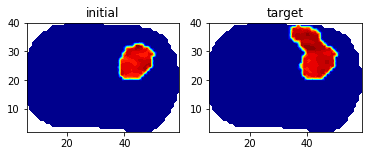

Optimizing...
Running the forward problem...
Solving reaction diffusion for time = 0.0
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Running the forward problem...
Solving reaction diffusion for time = 0.0
Plotting initial condition and target...


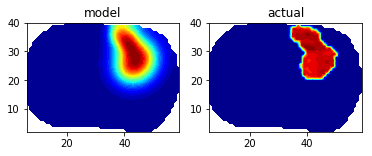

norm(k_opt) = 15.0480399815


TypeError: objective() takes exactly 5 arguments (4 given)

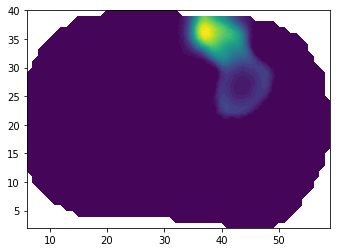

In [4]:
%matplotlib inline
from __future__ import print_function
from dolfin import *
from dolfin_adjoint import *
import numpy as np
import os, sys
import scipy.io as scio
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors

set_log_level(PROGRESS) 

class InterpolatedParameter(Expression):
    '''
        Class to get tumor cell distributions by interpolating based off matrices of tumor cell data
    '''
    def __init__(self,X,Y,image,**kwargs):
        self.X = X # A numpy array giving the X-spacing of the image
        self.Y = Y # Same for Y
        self.image = image # The image of measured material property    
    def eval_cell(self,values,x,cell):
        interp_handle = RegularGridInterpolator((self.X,self.Y),self.image)
        values[0] = interp_handle(x)
        
def interp(file_loc,mat_name):
    """
        Function to accept matlab .mat file with tumor data and interpolate values onto mesh
    """
    print("Interpolating "+mat_name+"...")
    mat = scio.loadmat(file_loc)[mat_name]
    mat = np.fliplr(mat.T)/theta  # Needs to be adjusted to fit the mesh correctly; also scaled
    x,y = mat.shape[0], mat.shape[1]
    mat_interp = InterpolatedParameter(np.linspace(1,x,x),np.linspace(1,y,y),mat,degree=1)
    return interpolate(mat_interp,V)

def vis_obs(initial_p,target_p,title1,title2):
    '''
        Compare two quantity plots, for example initial vs. target cellularity
        Accepts titles for each plot
    '''
    print("Plotting initial condition and target...")
    target_p = interpolate(target_p,V)
    cm1 = colors.ListedColormap([[0,1,0,1],[0,0,0,1],[1,0,0,1]])    
    cm2 = cm.get_cmap('jet')
    plt.figure()
    plt.subplot(1,2,1)
    plt.title(title1)
    plot(initial_p,cmap=cm2)
 
    plt.subplot(1,2,2)
    plt.title(title2)
    plot(target_p,cmap=cm2)
    plt.show()

def forward(initial_p,record=True, annotate=False):
    print("Running the forward problem...")
    
    """ 
        Here, we define the forward problem. 
    """
    
    '''
        - E(u) returns the Green-Lagrange strain tensor
        - sigma(...) returns the actual stress tensor
        - sigma_form(...) returns the stress tensor based on the cells (phi), elasticity coefficients, and a coefficient beta
        - vonmises(...) calculates the von Mises stress based on the actual stress tensor
    '''
    
    ## Define functions
    def E(u):
        return 0.5*(nabla_grad(u) + nabla_grad(u).T)
    def sigma(u):
        I = Identity(2)             # Identity tensor
        F = I + grad(u)             # Deformation gradient
        B = F*F.T
        C = F.T*F
        J = det(F)
        I1 = tr(C)
        sigma = lmbda*(J-1)*I+mu*(B-1./2*I1*I)/(J**(5./3))
        return sigma
    def vonmises(u):
        s = sigma(u) - (1./2)*tr(sigma(u))*Identity(2)  # deviatoric stress
        von_Mises = sqrt(3./2*inner(s, s))
        return project(von_Mises, V,annotate=annotate)
    def sigma_form(u, phi):
        I = Identity(2)             # Identity tensor
        F = I + grad(u)             # Deformation gradient
        Fs = F/(1+beta*phi)
        Bs = Fs*Fs.T
        Js  = det(Fs)
        return 1/(1+beta*phi)*(mu/(Js**(5./3))*(Bs-1./2*tr(Bs)*I)+lmbda*(Js-1)*I)

    # Set up linear elasticity problem
    U           = VectorFunctionSpace(mesh,'Lagrange',1)
    def boundary(x, on_boundary):
        return on_boundary
    bc          = DirichletBC(U, Constant((0.,0.)), boundary)
    du          = TrialFunction(U)
    u           = Function(U,annotate = annotate) 
    v           = TestFunction(U)
    p_n         = interpolate(initial_p,V)
    F_HE        = inner(sigma_form(u, p_n), E(v))*dx
    J_HE        = derivative(F_HE,u,du)
    
    ffc_options = {"quadrature_degree": 2, "cpp_optimize": True}
    parameters['form_compiler']['quadrature_degree'] = 2
    parameters['krylov_solver']['nonzero_initial_guess'] = True
    
    problem_HE  = NonlinearVariationalProblem(F_HE, u, bc, J=J_HE,
                                              form_compiler_parameters=ffc_options)
    solver_HE   = NonlinearVariationalSolver(problem_HE)
    prm1 = solver_HE.parameters
    prm1['newton_solver']['absolute_tolerance'] = 1E-7
    prm1['newton_solver']['relative_tolerance'] = 1E-6
    prm1['newton_solver']['maximum_iterations'] = 51
    prm1['newton_solver']['relaxation_parameter'] = 1.0
    prm1['newton_solver']['linear_solver'] = 'gmres'
    prm1['newton_solver']['preconditioner'] = 'ilu'
    prm1['newton_solver']['krylov_solver']['absolute_tolerance'] = 1E-8
    prm1['newton_solver']['krylov_solver']['relative_tolerance'] = 1E-6
    prm1['newton_solver']['krylov_solver']['maximum_iterations'] = 1000
    prm1['newton_solver']['krylov_solver']['nonzero_initial_guess'] = True
    def he():
        solver_HE.solve(annotate = annotate)
        return u

    # First iteration solving for displacement, and using the von mises stress field for D
    disp = he()
    vm   = vonmises(disp)
    D    = project(D0*exp(-gammaD*vm),V, annotate=annotate)
    
    # Set up reaction-diffusion problem
    dp          = TrialFunction(V)
    p           = Function(V, annotate = annotate)
    q           = TestFunction(V)
    F_RD        = (1/dt)*(p - p_n)*q*dx + D*dot(grad(q),grad(p))*dx - k*p*(1 - p)*q*dx  
    J_RD        = derivative(F_RD,p,dp)       

    # Prepare the solution
    t = 0.
        
    for n in range(num_steps):
        if (n%rtime == 0):
            print("Solving reaction diffusion for time = "+str(t))
            if record:        # save the current solution, k field, displacement, and diffusion
                # Rename parameters for saving
                u.rename('u','displacement')
                p_n.rename('phi_T','tumor fraction')
                vm.rename("vm","Von Mises")
                D.rename("D","diffusion coefficient")
                k.rename('k','k field')   
                file_results.write(p_n,t)
                file_results.write(u,t)
                file_results.write(k,t)
                file_results.write(vm,t)
                file_results.write(D,t)
        
        # Update current time and Compute solution
        t += dt
        problem_RD  = NonlinearVariationalProblem(F_RD, p, J=J_RD,form_compiler_parameters=ffc_options)
        solver_RD   = NonlinearVariationalSolver(problem_RD)
        prm = solver_RD.parameters
        prm['newton_solver']['absolute_tolerance'] = 1E-7
        prm['newton_solver']['relative_tolerance'] = 1E-6
        prm['newton_solver']['maximum_iterations'] = 51
        prm['newton_solver']['relaxation_parameter'] = 1.0
        prm['newton_solver']['linear_solver'] = 'gmres'
        prm['newton_solver']['preconditioner'] = 'ilu'
        prm['newton_solver']['krylov_solver']['absolute_tolerance'] = 1E-8
        prm['newton_solver']['krylov_solver']['relative_tolerance'] = 1E-6
        prm['newton_solver']['krylov_solver']['maximum_iterations'] = 1000
        prm['newton_solver']['krylov_solver']['nonzero_initial_guess'] = True
        solver_RD.solve(annotate=annotate)

        # Update previous solution
        p_n.assign(p)
        disp = he()
        vm   = vonmises(disp)
        D    = project(D0*exp(-gammaD*vm),V, annotate=annotate)
        
    return p

# Callback function for the optimizer; Writes intermediate results to a logfile
def eval_cb(j, m):
    """ The callback function keeping a log """
    print("objective = %15.10e " % j)

def objective(p, target_p, r_coeff1, r_coeff2, r_coeff3):
    return assemble(inner(p-target_p, p-target_p)*dx) + \
        r_coeff1*assemble(k*k*dx) + \
        r_coeff2*assemble(dot(grad(k),grad(k))*dx) + \
        r_coeff3*assemble(sqrt(dot(grad(p),grad(p))+eps)*dx)
        # assemble(inner(p-target_p, p-target_p)*dx) + r_coeff1*assemble(k*k*dx) + r_coeff2*assemble(dot(grad(k),grad(k))*dx)

def optimize(dbg=False):
    """ The optimization routine """
    print("Optimizing...")
    
    # Define the control
    m = [Control(k), Control(D0)]
    
    # Execute first time to annotate and record the tape
    p = forward(initial_p, False, True)

    J = objective(p, target_p, r_coeff1, r_coeff2, r_coeff3)

    # Prepare the reduced functional
    rf = ReducedFunctional(J,m,eval_cb_post=eval_cb)

    # upper and lower bound for the parameter field
    k_lb, k_ub = Function(V,annotate=False), Function(V,annotate=False)
    k_lb.vector()[:] = 0.
    k_ub.vector()[:] = 8.
    D_lb = Constant(0.)
    D_ub = Constant(10.)
    bnds = [[k_lb,D_lb],[k_ub,D_ub]]
    
    # Run the optimization
    m_opt = minimize(rf,method='L-BFGS-B', bounds=bnds, tol=1.0e-6,options={"disp":True,"gtol":1.0e-6})
    
    # Run the optimization
    #m_opt = minimize(rf,method='L-BFGS-B', tol=1.0e-6,options={"disp":True,"gtol":1.0e-6})
    
    return m_opt

#########################################################################
# MAIN 
#########################################################################
#global D0, k, dt, theta, mu, nu, lmbda, beta, gammaD, initial_p, target_p, file_results, V, mesh, num_steps,\
#    r_coeff1, r_coeff2, case, input_dir, output_dir, T
t1         = time()
r_coeff1 = 0.01
r_coeff2 = 0.001
r_coeff3 = 1.
eps = .01
input_dir  = "../rat-data/rat05/"
output_dir = './output/rat05'

# Prepare output file
file_results = XDMFFile(os.path.join(output_dir,'he.xdmf'))
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True
rtime = 20 # How often to record results

# Prepare a mesh
mesh = Mesh(input_dir+"gmsh.xml")
V    = FunctionSpace(mesh, 'CG', 1)

# Model parameters
T             = 2.0              # final time 
num_steps     = 20              # number of time steps
dt            = T/num_steps      # time step size
theta         = 50970.           # carrying capacity - normalize data by this
mu            = .42              # kPa, bulk shear modulus
nu            = .45              # poisson's ratio
lmbda         = 2*mu*nu/(1-2*nu) # lame parameter
beta          = 1.               # force coefficient for HE

# Load initial tumor condition data
initial_p = interp(input_dir+"tumor_t0.mat","tumor")
initial_p.rename('initial','tumor at day 0')
target_p  = interp(input_dir+"tumor_t2.mat","tumor")  
target_p.rename('target','tumor at day 2')

# Visualize initial cellularity and target cellularity
vis_obs(initial_p,target_p,'initial','target') 

# Initial guesses
D0     = Constant(1.)   # mobility or diffusion coefficient
k0     = Constant(2.)    # growth rate initial guess
k      = project(k0,V,annotate=False)
gammaD = Constant(.1)

# Optimization module
[k, D0] = optimize() # optimize the k field, gammaD, and D0 using the adjoint method provided by adjoint_dolfin
model_p = forward(initial_p,True, False) # run the forward model using the optimized k field
vis_obs(model_p,target_p,'model','actual')
plot(k)

print('norm(k_opt) = '+str(norm(k)))
print('J_opt = '+str(objective(model_p, target_p, r_coeff1, r_coeff2)))
print('J_opt (without regularization) = '+str(objective(model_p, target_p, 0., 0.)))
#print('gamma_D = '+str(gammaD.values()[0]))
print('D0 = '+str(D0.values()[0]))
print('Elapsed time is ' + str((time()-t1)/60) + ' minutes')



# Graphics from previous run that didn't load

[4.44796223]


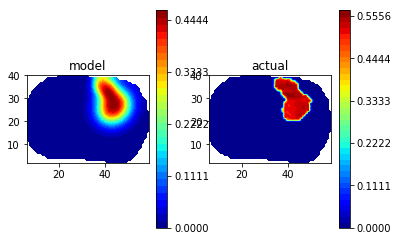

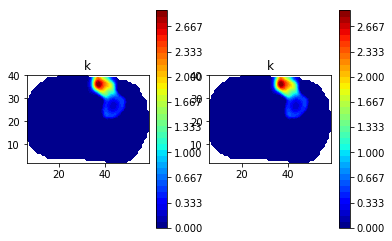

In [10]:
from numpy import fliplr, linspace, inf, max, ceil
import matplotlib.cm as cm
from matplotlib import colors
def vis_obs(first,second,title1,title2):
    '''
        Compare two quantity plots, for example initial vs. target cellularity
        Accepts titles for each plot
    '''
    cm_jet = cm.get_cmap('jet')
    m = max([first.compute_vertex_values(), second.compute_vertex_values()])
    f = plt.figure()
    
    plt.subplot(1,2,1)
    plt.title(title1)
    c = plot(first,cmap=cm_jet)
    f.colorbar(c, ticks = linspace(0,ceil(m),10))
 
    plt.subplot(1,2,2)
    plt.title(title2)
    c = plot(second,cmap=cm_jet)
    f.colorbar(c, ticks = linspace(0,ceil(m),10))
vis_obs(model_p,target_p,'model','actual')
vis_obs(k,k,'k','k')
print(D0.values())

# Trying to run with blood vessel k

Interpolating tumor...
Interpolating k...
Running the forward problem...
Solving reaction diffusion for time = 0.0
Plotting initial condition and target...


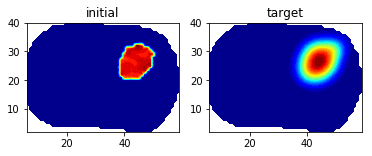

Optimizing...
Running the forward problem...
Solving reaction diffusion for time = 0.0
Running the forward problem...
Solving reaction diffusion for time = 0.0
Plotting initial condition and target...


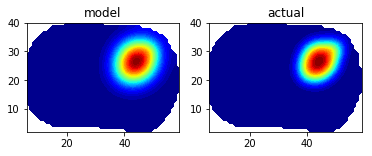

norm(k_opt) = 1.45412110382
J_opt = 176.851878684
J_opt (without regularization) = 0.96634473332
D0 = 3.659263841488601
Elapsed time is 10.8839010999 minutes


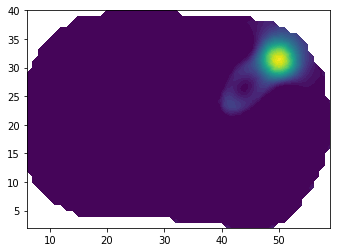

In [3]:
%matplotlib inline
from __future__ import print_function
from dolfin import *
from dolfin_adjoint import *
import numpy as np
import os, sys
import scipy.io as scio
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors

set_log_level(ERROR) 

class InterpolatedParameter(Expression):
    '''
        Class to get tumor cell distributions by interpolating based off matrices of tumor cell data
    '''
    def __init__(self,X,Y,image,**kwargs):
        self.X = X # A numpy array giving the X-spacing of the image
        self.Y = Y # Same for Y
        self.image = image # The image of measured material property    
    def eval_cell(self,values,x,cell):
        interp_handle = RegularGridInterpolator((self.X,self.Y),self.image)
        values[0] = interp_handle(x)
        
def interp(file_loc,mat_name,norm_val):
    """
        Function to accept matlab .mat file with tumor data and interpolate values onto mesh
    """
    print("Interpolating "+mat_name+"...")
    mat = scio.loadmat(file_loc)[mat_name]
    mat = np.fliplr(mat.T)/norm_val  # Needs to be adjusted to fit the mesh correctly; also scaled
    x,y = mat.shape[0], mat.shape[1]
    mat_interp = InterpolatedParameter(np.linspace(1,x,x),np.linspace(1,y,y),mat,degree=1)
    return interpolate(mat_interp,V)

def vis_obs(initial_p,target_p,title1,title2):
    '''
        Compare two quantity plots, for example initial vs. target cellularity
        Accepts titles for each plot
    '''
    print("Plotting initial condition and target...")
    target_p = interpolate(target_p,V)
    cm1 = colors.ListedColormap([[0,1,0,1],[0,0,0,1],[1,0,0,1]])    
    cm2 = cm.get_cmap('jet')
    plt.figure()
    plt.subplot(1,2,1)
    plt.title(title1)
    plot(initial_p,cmap=cm2)
 
    plt.subplot(1,2,2)
    plt.title(title2)
    plot(target_p,cmap=cm2)
    plt.show()

def forward(initial_p,record=True, annotate=False):
    print("Running the forward problem...")
    
    """ 
        Here, we define the forward problem. 
    """
    
    '''
        - E(u) returns the Green-Lagrange strain tensor
        - sigma(...) returns the actual stress tensor
        - sigma_form(...) returns the stress tensor based on the cells (phi), elasticity coefficients, and a coefficient beta
        - vonmises(...) calculates the von Mises stress based on the actual stress tensor
    '''
    
    ## Define functions
    def E(u):
        return 0.5*(nabla_grad(u) + nabla_grad(u).T)
    def sigma(u):
        I = Identity(2)             # Identity tensor
        F = I + grad(u)             # Deformation gradient
        B = F*F.T
        C = F.T*F
        J = det(F)
        I1 = tr(C)
        sigma = lmbda*(J-1)*I+mu*(B-1./2*I1*I)/(J**(5./3))
        return sigma
    def vonmises(u):
        s = sigma(u) - (1./2)*tr(sigma(u))*Identity(2)  # deviatoric stress
        von_Mises = sqrt(3./2*inner(s, s))
        return project(von_Mises, V,annotate=annotate)
    def sigma_form(u, phi):
        I = Identity(2)             # Identity tensor
        F = I + grad(u)             # Deformation gradient
        Fs = F/(1+beta*phi)
        Bs = Fs*Fs.T
        Js  = det(Fs)
        return 1/(1+beta*phi)*(mu/(Js**(5./3))*(Bs-1./2*tr(Bs)*I)+lmbda*(Js-1)*I)

    # Set up linear elasticity problem
    U           = VectorFunctionSpace(mesh,'Lagrange',1)
    def boundary(x, on_boundary):
        return on_boundary
    bc          = DirichletBC(U, Constant((0.,0.)), boundary)
    du          = TrialFunction(U)
    u           = Function(U,annotate = annotate) 
    v           = TestFunction(U)
    p_n         = interpolate(initial_p,V)
    F_HE        = inner(sigma_form(u, p_n), E(v))*dx
    J_HE        = derivative(F_HE,u,du)
    
    ffc_options = {"quadrature_degree": 2, "cpp_optimize": True}
    parameters['form_compiler']['quadrature_degree'] = 2
    parameters['krylov_solver']['nonzero_initial_guess'] = True
    
    problem_HE  = NonlinearVariationalProblem(F_HE, u, bc, J=J_HE,
                                              form_compiler_parameters=ffc_options)
    solver_HE   = NonlinearVariationalSolver(problem_HE)
    prm1 = solver_HE.parameters
    prm1['newton_solver']['absolute_tolerance'] = 1E-7
    prm1['newton_solver']['relative_tolerance'] = 1E-6
    prm1['newton_solver']['maximum_iterations'] = 51
    prm1['newton_solver']['relaxation_parameter'] = 1.0
    prm1['newton_solver']['linear_solver'] = 'gmres'
    prm1['newton_solver']['preconditioner'] = 'ilu'
    prm1['newton_solver']['krylov_solver']['absolute_tolerance'] = 1E-8
    prm1['newton_solver']['krylov_solver']['relative_tolerance'] = 1E-6
    prm1['newton_solver']['krylov_solver']['maximum_iterations'] = 1000
    prm1['newton_solver']['krylov_solver']['nonzero_initial_guess'] = True
    def he():
        solver_HE.solve(annotate = annotate)
        return u

    # First iteration solving for displacement, and using the von mises stress field for D
    disp = he()
    vm   = vonmises(disp)
    D    = project(D0*exp(-gammaD*vm),V, annotate=annotate)
    
    # Set up reaction-diffusion problem
    dp          = TrialFunction(V)
    p           = Function(V, annotate = annotate)
    q           = TestFunction(V)
    F_RD        = (1/dt)*(p - p_n)*q*dx + D*dot(grad(q),grad(p))*dx - k*p*(1 - p)*q*dx  
    J_RD        = derivative(F_RD,p,dp)       

    # Prepare the solution
    t = 0.
        
    for n in range(num_steps):
        if (n%rtime == 0):
            print("Solving reaction diffusion for time = "+str(t))
            if record:        # save the current solution, k field, displacement, and diffusion
                # Rename parameters for saving
                u.rename('u','displacement')
                p_n.rename('phi_T','tumor fraction')
                vm.rename("vm","Von Mises")
                D.rename("D","diffusion coefficient")
                k.rename('k','k field')   
                file_results.write(p_n,t)
                file_results.write(u,t)
                file_results.write(k,t)
                file_results.write(vm,t)
                file_results.write(D,t)
        
        # Update current time and Compute solution
        t += dt
        problem_RD  = NonlinearVariationalProblem(F_RD, p, J=J_RD,form_compiler_parameters=ffc_options)
        solver_RD   = NonlinearVariationalSolver(problem_RD)
        prm = solver_RD.parameters
        prm['newton_solver']['absolute_tolerance'] = 1E-7
        prm['newton_solver']['relative_tolerance'] = 1E-6
        prm['newton_solver']['maximum_iterations'] = 51
        prm['newton_solver']['relaxation_parameter'] = 1.0
        prm['newton_solver']['linear_solver'] = 'gmres'
        prm['newton_solver']['preconditioner'] = 'ilu'
        prm['newton_solver']['krylov_solver']['absolute_tolerance'] = 1E-8
        prm['newton_solver']['krylov_solver']['relative_tolerance'] = 1E-6
        prm['newton_solver']['krylov_solver']['maximum_iterations'] = 1000
        prm['newton_solver']['krylov_solver']['nonzero_initial_guess'] = True
        solver_RD.solve(annotate=annotate)

        # Update previous solution
        p_n.assign(p)
        disp = he()
        vm   = vonmises(disp)
        D    = project(D0*exp(-gammaD*vm),V, annotate=annotate)
        
    return p

# Callback function for the optimizer; Writes intermediate results to a logfile
def eval_cb(j, m):
    """ The callback function keeping a log """
    print("objective = %15.10e " % j)

def objective(p, target_p, r_coeff1, r_coeff2, r_coeff3):
    return assemble(inner(p-target_p, p-target_p)*dx) + \
        r_coeff1*assemble(k*k*dx) + \
        r_coeff2*assemble(dot(grad(k),grad(k))*dx) + \
        r_coeff3*assemble(sqrt(dot(grad(p),grad(p))+eps)*dx)
        # assemble(inner(p-target_p, p-target_p)*dx) + r_coeff1*assemble(k*k*dx) + r_coeff2*assemble(dot(grad(k),grad(k))*dx)

def optimize(dbg=False):
    """ The optimization routine """
    print("Optimizing...")
    
    # Define the control
    m = [Control(k), Control(D0)]
    
    # Execute first time to annotate and record the tape
    p = forward(initial_p, False, True)

    J = objective(p, target_p, r_coeff1, r_coeff2, r_coeff3)

    # Prepare the reduced functional
    rf = ReducedFunctional(J,m,eval_cb_post=eval_cb)

    # upper and lower bound for the parameter field
    k_lb, k_ub = Function(V,annotate=False), Function(V,annotate=False)
    k_lb.vector()[:] = 0.
    k_ub.vector()[:] = 8.
    D_lb = Constant(0.)
    D_ub = Constant(10.)
    bnds = [[k_lb,D_lb],[k_ub,D_ub]]
    
    # Run the optimization
    m_opt = minimize(rf,method='L-BFGS-B', bounds=bnds, tol=1.0e-6,options={"disp":True,"gtol":1.0e-6})
    
    # Run the optimization
    #m_opt = minimize(rf,method='L-BFGS-B', tol=1.0e-6,options={"disp":True,"gtol":1.0e-6})
    
    return m_opt

#########################################################################
# MAIN 
#########################################################################
#global D0, k, dt, theta, mu, nu, lmbda, beta, gammaD, initial_p, target_p, file_results, V, mesh, num_steps,\
#    r_coeff1, r_coeff2, case, input_dir, output_dir, T
t1         = time()
r_coeff1 = 0.01
r_coeff2 = 0.001
r_coeff3 = 1.
eps = .01
input_dir  = "../rat-data/rat05/"
output_dir = './output/rat05'

# Prepare output file
file_results = XDMFFile(os.path.join(output_dir,'he.xdmf'))
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True
rtime = 20 # How often to record results

# Prepare a mesh
mesh = Mesh(input_dir+"gmsh.xml")
V    = FunctionSpace(mesh, 'CG', 1)

# Model parameters
T             = 2.0              # final time 
num_steps     = 20              # number of time steps
dt            = T/num_steps      # time step size
theta         = 50970.           # carrying capacity - normalize data by this
mu            = .42              # kPa, bulk shear modulus
nu            = .45              # poisson's ratio
lmbda         = 2*mu*nu/(1-2*nu) # lame parameter
beta          = 1.               # force coefficient for HE
gammaD        = .1

# Load initial tumor condition data
initial_p = interp(input_dir+"tumor_t0.mat","tumor",theta)
initial_p.rename('initial','tumor at day 0')
D0 = Constant(1.5)
k = interp("../rat-data/k_synth0.mat","k",1)
target_p  = forward(initial_p, True, False) # interp(input_dir+"tumor_t2.mat","tumor")  
target_p.rename('target','tumor at day 2')

# Visualize initial cellularity and target cellularity
vis_obs(initial_p,target_p,'initial','target') 

# Initial guesses
D0     = Constant(1.5)   # mobility or diffusion coefficient
k0     = Constant(1.)    # growth rate initial guess
k      = project(k0,V,annotate=False)
gammaD = Constant(.1)

# Optimization module
[k, D0] = optimize() # optimize the k field, gammaD, and D0 using the adjoint method provided by adjoint_dolfin
model_p = forward(initial_p,True, False) # run the forward model using the optimized k field
vis_obs(model_p,target_p,'model','actual')
plot(k)

print('norm(k_opt) = '+str(norm(k)))
print('J_opt = '+str(objective(model_p, target_p, r_coeff1, r_coeff2, r_coeff3)))
print('J_opt (without regularization) = '+str(objective(model_p, target_p, 0., 0., 0.)))
#print('gamma_D = '+str(gammaD.values()[0]))
print('D0 = '+str(D0.values()[0]))
print('Elapsed time is ' + str((time()-t1)/60) + ' minutes')



Interpolating k...


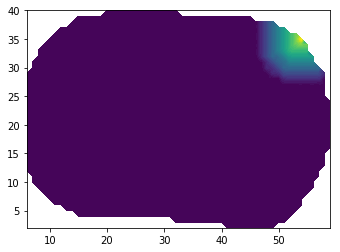

In [4]:
k_true = interp("../rat-data/k_synth0.mat","k",1)
plot(k_true)
